In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# np.zeros()
from skimage.draw import random_shapes
from skimage.segmentation import relabel_sequential

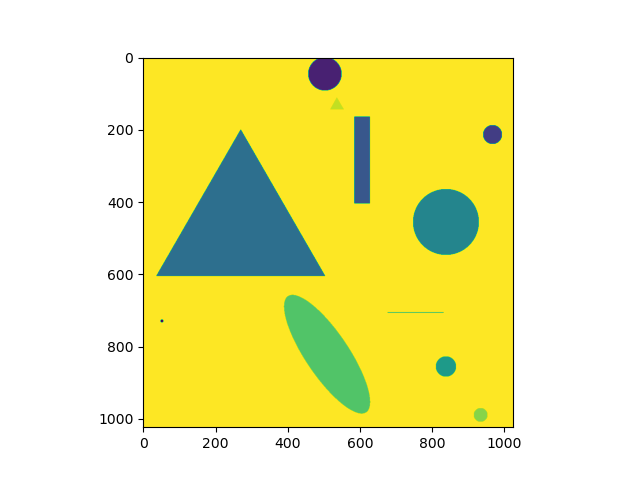

In [4]:
im_shape=(1024,1024)
min_shapes = 5
im1 =random_shapes(im_shape, 20, min_shapes=min_shapes)[0]
im1 = relabel_sequential(im1.sum(axis=-1))[0]
im2 =random_shapes(im_shape, 20, min_shapes=min_shapes)[0]
im2 = relabel_sequential(im2.sum(axis=-1))[0]

plt.figure()
plt.imshow(im1)

In [5]:
import numpy as np
import numba
from numba import jit


In [6]:
SQRT_2PI = np.sqrt(2 * np.pi)

@jit(nopython=True, parallel=True)
def gaussians(x, means, widths):
    '''Return the value of gaussian kernels.
    
    x - location of evaluation
    means - array of kernel means
    widths - array of kernel widths
    '''
    n = means.shape[0]
    result = np.exp( -0.5 * ((x - means) / widths)**2 ) / widths
    return result / SQRT_2PI / n

In [7]:
means = np.random.uniform(-1, 1, size=1000000)
widths = np.random.uniform(0.1, 0.3, size=1000000)

gaussians(0.4, means, widths)

array([1.67404304e-06, 8.55069057e-32, 1.21639285e-06, ...,
       2.04607590e-07, 4.89871622e-07, 1.39271340e-06])

In [8]:
gaussians_nothread = jit(nopython=True)(gaussians.py_func)

%timeit gaussians_nothread(0.4, means, widths)
%timeit gaussians(0.4, means, widths)

9.15 ms ± 617 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.01 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
from numba import int32

@jit((int32[:,:], int32[:,:], int32, int32), nopython=True)
def overlap_numba(prev, curr, shape1, shape2):
    arr = np.zeros((shape1, shape2), dtype=np.dtype("i"))
    for i in range(prev.shape[0]):
        for j in range(prev.shape[1]):
            arr[prev[i,j],curr[i,j]] += 1
    return arr



In [56]:
import os

In [60]:
os.environ['NUMBA_CACHE_DIR'] = "/tmp"

In [50]:
# @jit(nopython=True, parallel=True)
# def overlap_numba_parallel(prev, curr, shape):
#     arr = np.zeros(shape, dtype=np.dtype("i"))
#     for i in numba.prange(prev.shape[0]):
#         for j in range(prev.shape[1]):
#             arr[prev[i,j],curr[i,j]] += 1
#     return arr

In [51]:
shape = (int(np.max(im1)+1), int(np.max(im2)+1))
shape


(13, 9)

In [52]:
import fast_overlap

In [63]:
%time out = overlap_numba.py_func(im1.astype(np.int32), im2.astype(np.int32), *shape)
%time out = overlap_numba(im1.astype(np.int32), im2.astype(np.int32), *shape)
# %time out = overlap_numba_parallel(im1.astype(np.int32), im2.astype(np.int32), shape)
%time out = np.array(fast_overlap.overlap(im1.astype(np.int32), im2.astype(np.int32), shape))
%time out = np.array(fast_overlap.overlap_prange(im1.astype(np.int32), im2.astype(np.int32), shape))

CPU times: user 1.99 s, sys: 733 µs, total: 1.99 s
Wall time: 2 s
CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 3.3 ms
CPU times: user 3.29 ms, sys: 0 ns, total: 3.29 ms
Wall time: 3.12 ms
CPU times: user 90.1 ms, sys: 0 ns, total: 90.1 ms
Wall time: 14.8 ms


In [64]:
out = np.array(fast_overlap.overlap(im1.astype(np.int32), im2.astype(np.int32), shape))
out_p = np.array(fast_overlap.overlap_prange(im1.astype(np.int32), im2.astype(np.int32), shape))


In [66]:
out == out_p

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False, False, False]])

CPU times: user 1.15 s, sys: 741 ms, total: 1.89 s
Wall time: 1.03 s


In [33]:
plt.figure()
plt.imshow(overlap)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [36]:
idx = im1.flatten() == im2.flatten()

In [38]:
np.unique(im1.flatten()[idx], return_counts=True)

(array([11, 13], dtype=uint64), array([79, 89]))

In [40]:
np.intersect1d(im1, im2, return_indices=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=uint64),
 array([43553, 55777,    94, 31198,  7592, 63166, 53341, 59662, 61027,
        63271, 26492, 33450, 43743]),
 array([ 1399, 60944, 17379, 23383,  2604, 21219, 48098, 51155, 37453,
        14717, 18823, 18729,     0]))

In [42]:
idx = im1 == im2

In [44]:
flat1 = im1.flatten()
flat2 = im2.flatten()

idx = flat1 == flat2

In [45]:
out = np.zeros((19, 14))

In [ ]:
out.ravel()

In [ ]:
np.ravel()

In [ ]:
# identify the unique values:
uniques = np.unique(data)

# dummy for each row
a = (data[...,None] == uniques).sum(1)

# output
out = np.einsum('ij,kj->ik',a,a)